In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers # helps in the generation of a random circuit

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
from torchvision import datasets

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from tensorflow.keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [12]:
import cv2

train_images_gray_scale = []
test_images_gray_scale = []
for i in range(len(train_images)):
    train_images_gray_scale.append(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2GRAY))

for i in range(len(test_images)):
    test_images_gray_scale.append(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2GRAY))

train_images_gray_scale = np.array(train_images_gray_scale)
test_images_gray_scale = np.array(test_images_gray_scale)


train_images_gray_scale = train_images_gray_scale / 255
test_images_gray_scale = test_images_gray_scale / 255

train_images_gray_scale = train_images_gray_scale[..., tf.newaxis]
test_images_gray_scale = test_images_gray_scale[..., tf.newaxis]

In [ ]:
n_epochs = 30    # Number of optimization epochs
lr = 0.05  # Learning rates
n_train = 1000    # no of images for training
n_test = 100    # no of images for testing
BATCH_SIZE = 256

In [13]:
# train_images = train_images_gray_scale[:n_train]
# train_labels = train_labels[:n_train]
# test_images = train_images_gray_scale[:n_test]
# test_labels = test_labels[:n_test]

train_images = train_images_gray_scale
train_labels = train_labels
test_images = train_images_gray_scale
test_labels = test_labels


In [14]:
train_images.shape

(50000, 32, 32, 1)

In [15]:
class Quanvolutional_Layer(keras.layers.Layer):

  def __init__(self,size_filter,layers_filter,stride_filter,padding):
    super(Quanvolutional_Layer,self).__init__()
    self.size_filter   = size_filter
    self.layers_filter = layers_filter
    self.stride_filter = stride_filter
    self.padding       = padding
    # Based on the quanvolutional filter size we set up appropriate number of wires since each pixel gets assigned a qubit (the encoding we went with)
    self.dev           = qml.device("default.qubit", wires=(self.size_filter*self.size_filter))
    # Random parameters required for each quantum convolutional filter based on the number of wires i.e. filter size
    self.rand_params   = np.random.uniform(high=2 * np.pi, size=(layers_filter, (size_filter*size_filter)))
    print("Created Basic Properties")

  # The qfilter generted will have the following gate properties :
  # 1) Encoding  : Ry rotation gate where the angles are scaled by PI
  # 2) Ciruit    : Of n_layers random in nature
  # 3) Decoding  : 4 expectation value measurements
  # decorator for quantum node

  def creator(self,phi):
    print(phi)

    @qml.qnode(self.dev,interface="tf")
    def circuit(self,phi):
      print("Reached inside")
      # Encoding on each of the filter value along each wire
      for j in range(self.size_filter*self.size_filter):
        qml.RY(np.pi * phi[j].numpy(), wires=j)
      # Random quantum circuit generation based on the random paramters we chose
      RandomLayers(self.rand_params, wires=list(range(self.size_filter*self.size_filter)))
      #Measurement producing 4 classical output values, each of this value is plugged along a channel
      return [qml.expval(qml.PauliZ(j)) for j in range(self.size_filter*self.size_filter)]
    
    return circuit(self,phi)

  def call(self,image):
    # 2x2 filter with stride 1 and passes the data through the quantum circuit
    # the output of the qunatum ciruit is 4 that is mapped into 4 different channels indicating the same pixel
    calc = math.floor((image.shape[1]+2*self.padding-self.size_filter)/self.stride_filter) + 1
    out = np.zeros((calc,calc,(self.size_filter*self.size_filter)))
    print(image.shape)
    print(out.shape)
    
    # steps of stride
    index = 0 
    for i in image:
      for j in range(0, i.shape[0], self.stride_filter):
        for k in range(0, i.shape[1], self.stride_filter):
          print("Looper")
          # The cicuit remains the same because the uniform random sampling is done only once
          q_results = self.creator([i[j, k, 0], i[j, k + 1, 0], i[j + 1, k, 0], i[j + 1, k + 1, 0]])
          print(q_results)
          # appropriate expectation value is assigned to right channel
          for c in range((self.size_filter*self.size_filter)):
            out[j // 2, k // 2, c] = q_results[c]
      index+=1
    return out


In [16]:
class Quanvolutional_Layer():

  def __init__(self,size_filter,layers_filter,stride_filter,padding):
    self.size_filter   = size_filter         # Determines the number of qubits to be required for the random cicuit (2-4)[time increases NP hard]
    self.layers_filter = layers_filter       # Number of random circuits since each filter is a realization of a circuit
    self.stride_filter = stride_filter       # Stride same meaning as classical counterpart
    self.padding       = padding             # Experimental feature ***Not Implemented***

    # Circuit design i.e. number of qubits required for encoding
    self.dev           = qml.device("default.qubit", wires=self.size_filter*self.size_filter)

    # Along each circuit we require (filter_size)^2 parameters randomly initialized
    self.rand_params   = np.random.uniform(high=2 * np.pi, size=(self.layers_filter, (self.size_filter*self.size_filter)))
    # print("Created Basic Properties")


  # The qfilter generted will have the following gate properties :
  # 1) Encoding  : Ry rotation gate where the angles are scaled by PI
  # 2) Ciruit    : Of n_layers random in nature
  # 3) Decoding  : 4 expectation value measurements
  # decorator for quantum node
  def creator(self,phi):
    # Due the decorator access we specified a function inside another function

    @qml.qnode(self.dev)
    def circuit(phi):
      # List containg all qubit outputs
      op_list = []

      # Encoding on each of the filter value along each wire
      for j in range(self.size_filter*self.size_filter):
        qml.RY(np.pi * phi[j], wires=j) # BloC sphere mapping

      # Random quantum circuit generation based on the random paramters we chose
      # The first dimension of rand_params (adjusts the number of layers we care about they are weights)
      # Iterating one filter at a time
      for k in self.rand_params:
        tmp = np.expand_dims(k,axis=0) # convert into 1 layer, number of qubits
        RandomLayers(tmp, wires=list(range(self.size_filter*self.size_filter)))
        for j in range(self.size_filter*self.size_filter):
          op_list.append(qml.expval(qml.PauliZ(j)))
      return op_list

    # op_list of shape : number of filters, number of qubits
    op_list = circuit(phi)
    op_list = np.array(op_list)
    return list(np.reshape(op_list, (self.layers_filter, (self.size_filter*self.size_filter))))

  def call(self,image):

    # Sanity check wether the paramters specified is alright for the image dimensions
    calc = math.floor((image.shape[1]+2*self.padding-self.size_filter)/self.stride_filter) + 1
    if calc <1:
      return -1
    # Stide reductions along the height and width dim & filter size = number of filters * number of qubits
    out = np.zeros((calc,calc,self.layers_filter*(self.size_filter*self.size_filter)))
    # print(image.shape)
    # print(out.shape)
    

    # Output collection array
    collection = []
    index = 0
    for i in image:
      out = np.zeros((calc,calc,self.layers_filter*(self.size_filter*self.size_filter)))
      # Progress checker
      # print("Image processed :",index+1)
      # Stride based steps
      for j in range(0, i.shape[0], self.stride_filter):
        for k in range(0, i.shape[1], self.stride_filter):
          phi = []
          # Padding not yet implemented
          if(j+self.size_filter > i.shape[0]) | (k+self.size_filter > i.shape[1]):
            continue
          for l in range(j,j+self.size_filter): 
            for m in range(k,k+self.size_filter):
              phi.append(i[l][m][0])
              
          q_results = self.creator(phi)
          
          ctr = 0
          for x in q_results:
            for y in range(len(x)):
              out[j//self.stride_filter, k//self.stride_filter,ctr] = x[y]
              ctr+=1
      collection.append(out) 
      index+=1
    return collection


In [8]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [21]:
# Quan2D = Quanvolutional_Layer(2,1,2,0)
# op_train = Quan2D.call(train_images)

# op_train = np.asarray(op_train, dtype=np.float32)

# op_test  = Quan2D.call(test_images)
# op_test  = np.asarray(op_test, dtype=np.float32)
# print(op_train.shape)
# print(op_test.shape)

from tqdm import tqdm
import numpy as np


Quan2D = Quanvolutional_Layer(2,1,2,0)

def apply_qnn_with_progress(images, layer):
    n_samples = images.shape[0]  # Get number of samples
    output = []

    # Use tqdm to track progress
    with tqdm(total=n_samples, desc="Processing images", unit="image") as pbar:
        for i in range(n_samples):
            # Apply Quanvolutional layer to each image
            result = layer.call(images[i])  # Reshape if necessary
            output.append(np.asarray(result, dtype=np.float32))
           
            # Update progress bar after processing each image
            pbar.update(1)

    return np.array(output)

# Apply the Quanvolutional layer to the training images with a progress bar
op_train = apply_qnn_with_progress(train_images, Quan2D)

# Apply the Quanvolutional layer to the test images with a progress bar
op_test = apply_qnn_with_progress(test_images, Quan2D)

# Optionally print output shapes after the process completes
print("Processed training images shape:", op_train.shape)
print("Processed test images shape:", op_test.shape)

Processing images: 100%|██████████| 50000/50000 [00:18<00:00, 2757.39image/s]


MemoryError: Unable to allocate 6.10 GiB for an array with shape (50000, 32, 16, 16, 4) and data type float32

In [ ]:
import numpy as np
np.save("op_train_CIFR.csv", op_train)
np.save("op_test.csv_CIFR", op_test)
np.save("train_labels_CIFR",train_labels)
np.save("test_labes_CIFR", test_labels)

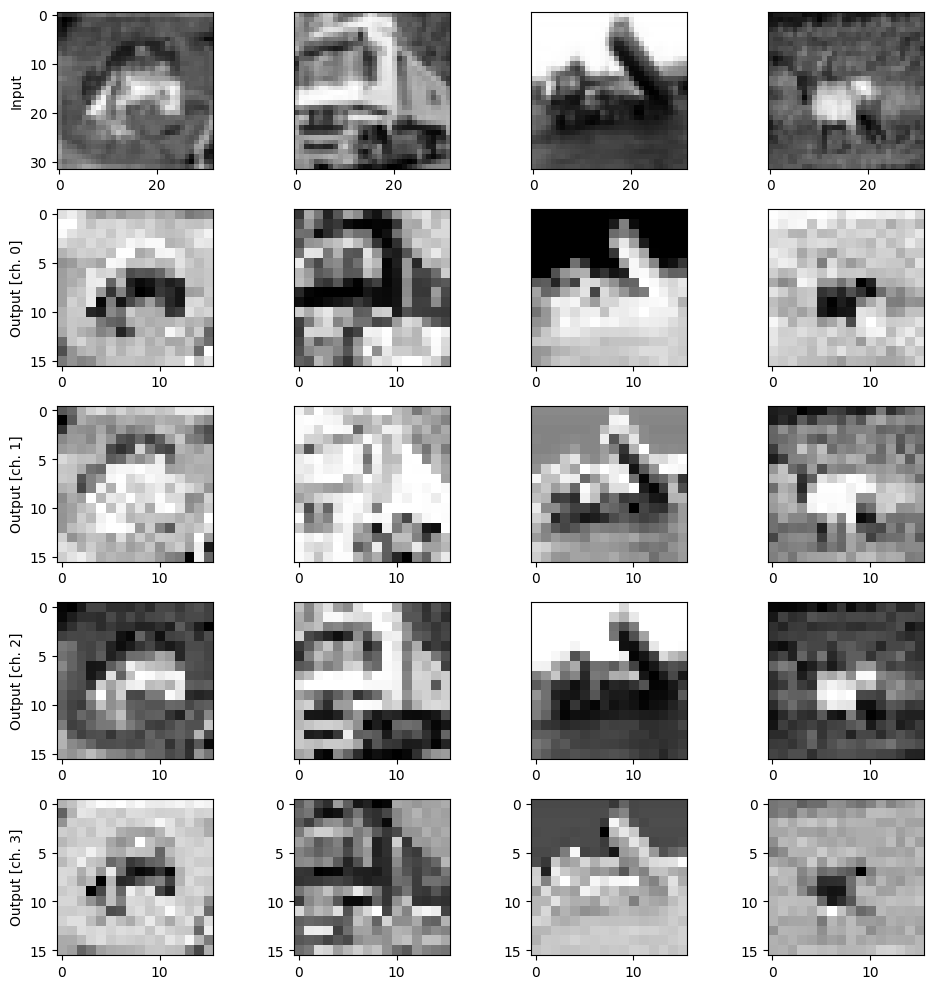

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(op_train[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation="softmax")
    ])

model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

In [ ]:
history = model.fit( op_train,
                     train_labels,
                     validation_data=(op_test, test_labels),
                     batch_size=4,
                     epochs=n_epochs,
                     verbose=2,)

Epoch 1/30
250/250 - 1s - 4ms/step - accuracy: 0.1750 - loss: 3.1752 - val_accuracy: 0.0600 - val_loss: 4.4562
Epoch 2/30
250/250 - 0s - 1ms/step - accuracy: 0.3060 - loss: 2.4623 - val_accuracy: 0.1200 - val_loss: 4.8525
Epoch 3/30
250/250 - 0s - 941us/step - accuracy: 0.3820 - loss: 2.1078 - val_accuracy: 0.0700 - val_loss: 4.3025
Epoch 4/30
250/250 - 0s - 1ms/step - accuracy: 0.4340 - loss: 1.8547 - val_accuracy: 0.0400 - val_loss: 4.8605
Epoch 5/30
250/250 - 0s - 742us/step - accuracy: 0.4800 - loss: 1.6633 - val_accuracy: 0.1300 - val_loss: 4.6261
Epoch 6/30
250/250 - 0s - 759us/step - accuracy: 0.5350 - loss: 1.4513 - val_accuracy: 0.1000 - val_loss: 5.1404
Epoch 7/30
250/250 - 0s - 772us/step - accuracy: 0.6010 - loss: 1.2531 - val_accuracy: 0.0700 - val_loss: 5.0503
Epoch 8/30
250/250 - 0s - 764us/step - accuracy: 0.6130 - loss: 1.1935 - val_accuracy: 0.0900 - val_loss: 4.8112
Epoch 9/30
250/250 - 0s - 921us/step - accuracy: 0.6500 - loss: 1.0599 - val_accuracy: 0.1000 - val_lo